In [ ]:
!pip install nvcc4jupyter
%load_ext nvcc4jupyter

Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmpydckvqhw".


In [ ]:
!nvidia-smi
!nvcc --version

Tue Apr 15 04:38:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#Terminologies

1. **Kernel**: A small program that runs on the GPU. Think of it as a job you give to all the workers, like “add two numbers.”
2. **Threads**: The individual workers. Each thread does the same job but on different pieces of data. For example, one thread adds 1+2, another adds 3+4.
3. **Thread Blocks**: Threads are grouped into teams called blocks. Each block is like a small crew that works closely together. A block can have up to 1024 threads (like 1024 workers in one crew).
4. **Grid**: All the blocks together form a grid. It’s like all the crews working on the same big project. A grid can have thousands of blocks.

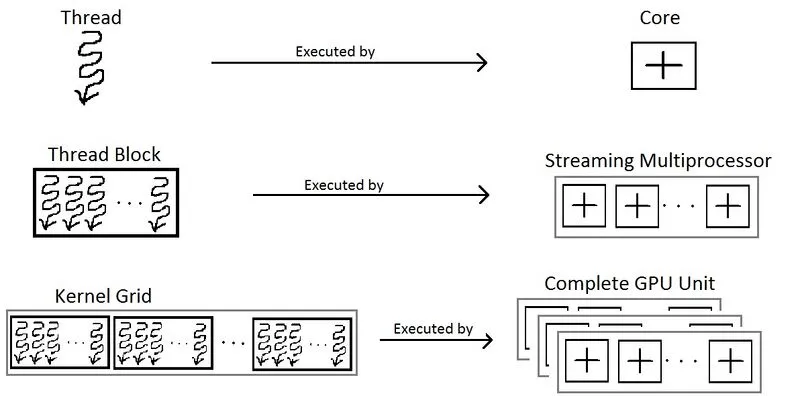

5. **Warps**: Threads in a block are split into groups of 32 threads called warps. It’s like a mini-team that moves together, doing the same step at the same time.
6. **Streams**: A way to line up jobs so some can run at the same time, like scheduling tasks to keep the GPU busy.
7. **Host vs. Device**:
    - Host: The CPU that gives orders and sends data.
    - Device: The GPU that does the fast calculations.
8. **Memory Limits**:
    - Threads per Block: Max 1024 threads.
    - Blocks per Grid: Millions possible, but depends on the GPU.
    - Shared Memory per Block: Up to 48KB.
    - Registers per Thread: Up to 255, but only about 64KB total per block (shared among threads).
    - If you use too much memory or too many threads, the GPU might not be able to run the job.
9. **Memory (Storage)**: Threads need places to store numbers while working.
    - **Global Memory**: A big storeage room all threads can use, but it's slow. GPU have gigabytes of global memory.
    - **Shared Memory**: A small, fast storage area **for one block to share**. Each block gets up to **48KB**.
    - **Registers**: Tiny, super fast storage for each thread. Each thread gets up to **255 registers**.
    - **Constant Memory**: A special read-only storage for data all thread use. Limited to **64KB** total.
    - **Textual Memory**: A storage type food for pictures or 3D data. Like a map threads can look at.
10. **How It Works**: The CPU sends the kernel (job) and data to the GPU. The GPU splits the work across thousands of threads in blocks, and they all calculate at once.

In [ ]:
%%writefile check_resource_limit.cu

#include<stdio.h>

// This code snippet is used to check the maximum threads can be in one block for this particular GPU
int main(){
    int device;
    cudaDeviceProp props;
    cudaGetDevice(&device);
    cudaGetDeviceProperties(&props, device);
    printf("Maximum threads per block: %d\n", props.maxThreadsPerBlock);
}

Overwriting check_resource_limit.cu


In [ ]:
!nvcc check_resource_limit.cu -o resource_check -arch=compute_75 -code=sm_75 --generate-code arch=compute_75,code=sm_75

In [ ]:
!./resource_check

Maximum threads per block: 1024


In [ ]:
%%writefile vector_add.cu

#include <stdio.h>

// Host: the CPU
// Device: The GPU
// Kernel: a function that runs on the GPU and is called from the CPU


// __global__ is use to define a kernel.
__global__ void AddTwoVectors(float A[], float B[], float C[]) {
    int i = threadIdx.x;    // Each thread is given a unique threadID
    C[i] = A[i] + B[i];
}

int main(){
    int N = 1000;
    float A[N], B[N], C[N];

    // Initialize vectors A and B
    for (int i = 0; i < N; i++) {
        A[i] = 1;
        B[i] = sinf(i * 0.1f);
    }


    float *d_A, *d_B, *d_C;     // Device pointers for vectors A, B, and C

    /*
    Note that in CUDA programming, you can't directly use host arrays (like A, B, and C) with kernel launches (<<<number_of_blocks, number_of_threads_per_block>>>).

    CUDA kernel operate on device memory, so you need to pass device pointers (d_A, d_B, and d_C) to the kernel for it to operate on.

    Beyond that, we need to allocate memory on the device by using cudaMalloc, and copy data between host and device using cudaMemcpy.
    */

    // Allocate memory on the device for vectors A, B, and C
    cudaMalloc((void **)&d_A, N * sizeof(float));
    cudaMalloc((void **)&d_B, N * sizeof(float));
    cudaMalloc((void **)&d_C, N * sizeof(float));


    // Copy vectors A and B from host to device
    cudaMemcpy(d_A, A, N * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, B, N * sizeof(float), cudaMemcpyHostToDevice);


    // The number of CUDA threads that execute the above kernel can be spefified using <<< >>> notation.
    // Kernel invocation with N threads
    AddTwoVectors<<<1, N>>>(d_A, d_B, d_C);


    /*

    cudaDeviceSynchronize() is used to synchronize the device and the host thread.

    When this function is called, the host thread will wait until all previously issued CUDA commands on the device are completed before continuing execution.
    */


    // Check for errors in kernel launch (e.g. invalid configuration)
    cudaError_t error = cudaGetLastError();


    if(error != cudaSuccess) {
        printf("CUDA error: %s\n", cudaGetErrorString(error));
        exit(-1);
    }


    // Wait until all CUDA threads are executed
    cudaDeviceSynchronize();


    // copy vector C from device to host
    cudaMemcpy(C, d_C, N * sizeof(float), cudaMemcpyDeviceToHost);


    // Print the first 10 elements of C for verification
    printf("First 10 elements of C:\n");
    for (int i = 0; i < 10; i++) {
        printf("C[%d] = %f\n", i, C[i]);
    }

    // Save the entire C array to a file for plotting
    FILE *fp = fopen("vector_c.txt", "w");
    if (fp == NULL) {
        printf("Error opening file!\n");
        exit(-1);
    }
    for (int i = 0; i < N; i++) {
        fprintf(fp, "%f\n", C[i]);
    }
    fclose(fp);


    // Free device memory
    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);
}


Writing vector_add.cu


In [ ]:
!nvcc vector_add.cu -o vector_add -arch=compute_75 -code=sm_75 --generate-code arch=compute_75,code=sm_75

In [ ]:
!./vector_add

First 10 elements of C:
C[0] = 1.000000
C[1] = 1.099833
C[2] = 1.198669
C[3] = 1.295520
C[4] = 1.389418
C[5] = 1.479426
C[6] = 1.564642
C[7] = 1.644218
C[8] = 1.717356
C[9] = 1.783327


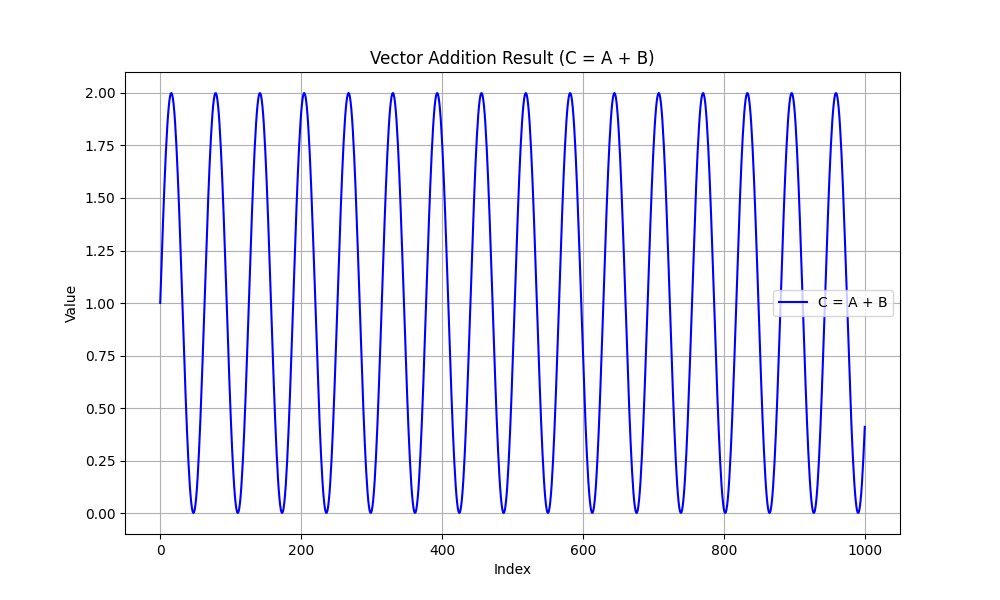

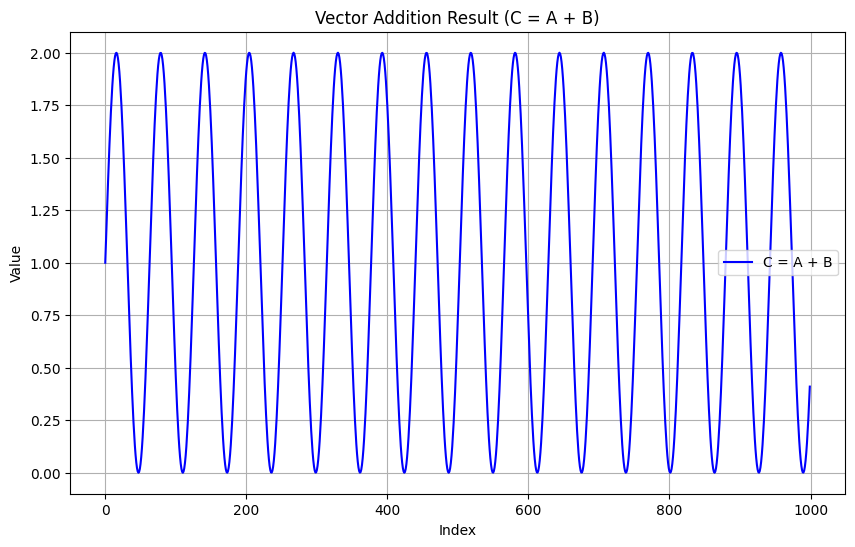

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load the data from the file
with open("vector_c.txt", "r") as f:
    C = [float(line.strip()) for line in f]

# Create an index array for the x-axis (0 to 999)
x = np.arange(len(C))

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(x, C, label='C = A + B', color='blue')
plt.title('Vector Addition Result (C = A + B)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

# Save the plot to a file (since plt.show() isn't used in Colab as per guidelines)
plt.savefig('vector_add_plot.png')

# Display the plot in Colab (optional, for user to see immediately)
from IPython.display import Image
Image('vector_add_plot.png')

# Problem: The above code is not fully optimized for running on GPU

In the example code snippet above, we run 1 block with N = 1000 threads. This is fine because it is still in the GPU limitation constraint (each block can only have up to 1024 threads).
<p>
Therefore, we need more blocks to execute much more threads in order to process a much larger vector.
<p>
Also, blocks are organized into grids, as illustrated here:

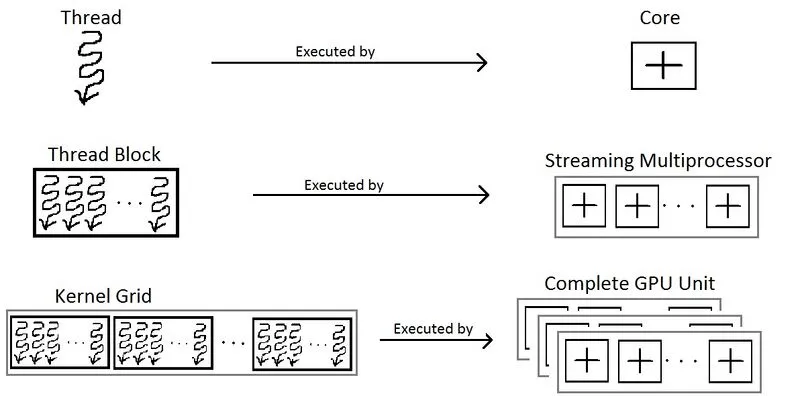

<p>
The thread ID can be accessed using:

```cpp
int i = blockIdx *blockDim.x + threadIdx.x
```

where:

    - `blockIdx.x * blockDim.x` finds the starting index for the block (e.g., block 0 starts at 0, block 1 starts at 1024 if blockDim.x = 1024).
    - Adding `threadIdx.x` pinpoints the thread’s position within that block.

In [ ]:
%%writefile vector_addition_updated.cu

#include <stdio.h>

// Kernel definition
__global__ void AddTwoVectors(float A[], float B[], float C[], int N){
    int i = blockIdx.x * blockDim.x + threadIdx.x; // get the thread ID

    if (i < N){
        // to avoid exceeding array limit
        C[i] = A[i] + B[i];
    }
}


int main() {
    int N = 500000;   // Size of the vectors
    int threads_per_block;
    int device;

    // Check for the limitations of the number of threads per block for the current GPU
    cudaDeviceProp props;
    cudaGetDevice(&device);
    cudaGetDeviceProperties(&props, device);
    threads_per_block = props.maxThreadsPerBlock;
    printf("Maximum threads per block for current GPU: %d\n", threads_per_block);


    // Register arrays for vectors A, B, and C
    float A[N], B[N], C[N];

    // Initialize vectors A and B
    for (int i = 0; i < N; i++){
        A[i] = 1;
        B[i] = sinf(i * 0.1f);
    }


    // Device pointers for vectors A, B, and C
    float *d_A, *d_B, *d_C;


    // Allocate memory on the device for the above vectors
    cudaMalloc((void **)&d_A, N * sizeof(float));
    cudaMalloc((void **)&d_B, N * sizeof(float));
    cudaMalloc((void **)&d_C, N * sizeof(float));


    // Copy vectors A and B from host to device
    cudaMemcpy(d_A, A, N * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, B, N * sizeof(float), cudaMemcpyHostToDevice);


    // Kernel invocation with multiple blocks,
    // as well as threads_per_block threads
    int number_of_blocks = (N + threads_per_block - 1) / threads_per_block;
    AddTwoVectors<<<number_of_blocks, threads_per_block>>>(d_A, d_B, d_C, N);


    // Check for CUDA error
    cudaError_t error = cudaGetLastError();
    if (error != cudaSuccess) {
        printf("CUDA error: %s\n", cudaGetErrorString(error));
        exit(-1);
    }


    // Wait until all CUDA threads are executed
    cudaDeviceSynchronize();


    // Copy the resulting vector from device to host
    cudaMemcpy(C, d_C, N * sizeof(float), cudaMemcpyDeviceToHost);


    printf("First 10 elements of C:\n");
    for (int i = 0; i < 10; i++) {
        printf("C[%d] = %f\n", i, C[i]);
    }


    // Free device memory
    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);
}

Overwriting vector_addition_updated.cu


In [ ]:
!nvcc vector_addition_updated.cu -o vector_add_updated -arch=compute_75 -code=sm_75 --generate-code arch=compute_75,code=sm_75

In [ ]:
!./vector_add_updated

Maximum threads per block for current GPU: 1024
First 10 elements of C:
C[0] = 1.000000
C[1] = 1.099833
C[2] = 1.198669
C[3] = 1.295520
C[4] = 1.389418
C[5] = 1.479426
C[6] = 1.564642
C[7] = 1.644218
C[8] = 1.717356
C[9] = 1.783327


# Multidimensional Threads

Now we know how to increase performance of a simple array operation.

But when dealing with deep learning models, we need to handle `matrix` and `tensor` operations.

In the above example, we only used `one-dimensional blocks` with N threads. However, it is also possible to execute `multidimensional thread blocks` (up to 3 dimensions).

So, for convenience, we can run a thread block of $N \times M$ threads if we need to run matrix operations.

In this case, we could obtain the matrix ros columns indices as `row = threadIdx.x, col = threadIdx.y`.

Also, for convenience, we can use `dim3` variable type to define the `number_of_blocks` and `threads_per_block`.

## Clarification on Thread, Block, and Grid dimensions according to data types


### 1D Vectors (like your example)
- **Job**: Add two vectors, `A + B = C`. Each vector has `N` elements, like `[1, 2, 3, ...]`.
- **Why 1D?** The vector is a straight line. You move in one direction (left to right) to add each pair (`A[i] + B[i]`).
- **How Threads Work**:
  - Each thread does one addition (e.g., thread 0 does `C[0] = A[0] + B[0]`, thread 1 does `C[1]`, etc.).
  - Organize threads in a **1D block** (a line of workers, e.g., 256 threads).
  - If `N` is large (say 1000), you need multiple blocks. A **1D grid** (a line of blocks) splits the work.
  - Example: For `N = 1000`, use 256 threads per block. You’d need `(1000 + 255) / 256 = 4` blocks to cover all elements.
- **Picture It**: Imagine a long row of boxes (vector elements). Workers (threads) line up in groups (blocks) to each grab one box and add numbers.

### 2D Matrices
- **Job**: Add two matrices, `A + B = C`. Each matrix is a table with `N` rows and `M` columns, like:
  ```
  A = [ [1, 2],
        [3, 4] ]
  ```
- **Why 2D?** The matrix is a grid with rows and columns. You need to move in two directions (up-down for rows, left-right for columns) to hit every element.
- **How Threads Work**:
  - Each thread adds one element (e.g., thread at position (0,0) does `C[0,0] = A[0,0] + B[0,0]`).
  - Organize threads in a **2D block** (a square of workers, e.g., 16x16 = 256 threads). Each thread has a row (`threadIdx.y`) and column (`threadIdx.x`).
  - Use a **2D grid** (a grid of blocks) to cover the whole matrix. If the matrix is 512x512, you might use `(512 + 15) / 16 = 32` blocks in each direction, so a 32x32 grid.
- **Picture It**: Imagine a checkerboard (matrix). Workers are grouped in small squares (2D blocks). Each worker grabs one square (element) to add numbers. Blocks are arranged in a bigger grid to cover the whole board.

### 3D Objects (like a 3D cube or tensor)
- **Job**: Add two 3D arrays, `A + B = C`. Each array is a cube with `N` rows, `M` columns, and `P` layers (like a stack of matrices).
- **Why 3D?** The data is a cube, so you move in three directions: up-down (rows), left-right (columns), and front-back (layers).
- **How Threads Work**:
  - Each thread adds one element at a position (row, column, layer).
  - Organize threads in a **3D block** (a cube of workers, e.g., 8x8x4 = 256 threads). Each thread has `threadIdx.x` (column), `threadIdx.y` (row), `threadIdx.z` (layer).
  - Use a **3D grid** to cover the cube. For a 64x64x64 array, you might use `(64 + 7) / 8 = 8` blocks for rows/columns and `(64 + 3) / 4 = 16` for layers.
- **Picture It**: Imagine a Rubik’s cube. Workers are grouped in small cubes (3D blocks). Each worker grabs one tiny cube piece to add numbers. Blocks are arranged in a bigger 3D grid to cover the whole cube.

### Simple Rule:
- The shape of your data (vector, matrix, cube) decides the shape of your blocks and grid:
  - **1D vector** (line) → **1D blocks**, **1D grid**. Threads line up to hit each element.
  - **2D matrix** (table) → **2D blocks**, **2D grid**. Threads form squares to hit each row/column.
  - **3D array** (cube) → **3D blocks**, **3D grid**. Threads form cubes to hit each row/column/layer.
- Always pick block sizes (e.g., 256 threads for 1D, 16x16 for 2D, 8x8x4 for 3D) that:
  - Fit your GPU (max 1024 threads per block).
  - Divide the data nicely (use `(size + blockSize - 1) / blockSize` to calculate blocks).


In [66]:
%%writefile matrix_addition.cu

#include <stdio.h>


// kernel definition
__global__ void AddTwoMatrices(float *A, float *B, float *C, int N){
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int column = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < N && column < N){
        int idx = row * N + column;
        C[idx] = A[idx] + B[idx];   // Use this way of idexing since GPU memory is linear
    }
}


int main(){
    int N = 512; // operate on 512x512 matrices
    dim3 threads_per_block(16, 16);   // 16 x 16 = 256 threads per block
    dim3 gridDim((N + 15) / 16, (N + 15) / 16);    // 2D grid to cover NxN


    // Dynamically allocate host arrays
    float *A = (float *)malloc(N * N * sizeof(float));
    float *B = (float *)malloc(N * N * sizeof(float));
    float *C = (float *)malloc(N * N * sizeof(float));


    // Initialize arrays A and B
    for (int i = 0; i < N; i++){
        for (int j = 0; j < N; j++){
            int idx = i * N + j;
            A[idx] = i + 10;
            B[idx] = sinf(i * 0.1f);
        }
    }


    // Create pointers for these arrays on GPU
    float *d_A, *d_B, *d_C;


    // Allocate memory on the GPU for these arrays
    cudaMalloc((void **)&d_A, N * N * sizeof(float));
    cudaMalloc((void **)&d_B, N * N * sizeof(float));
    cudaMalloc((void **)&d_C, N * N * sizeof(float));


    // Copy matrices A and B form host to device
    cudaMemcpy(d_A, A, N * N * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, B, N * N * sizeof(float), cudaMemcpyHostToDevice);


    // Launch kernel
    AddTwoMatrices<<<gridDim, threads_per_block>>>(d_A, d_B, d_C, N);


    // Check for CUDA error
    cudaError_t error = cudaGetLastError();
    if (error != cudaSuccess) {
        printf("CUDA error: %s\n", cudaGetErrorString(error));
        exit(-1);
    }


    // Wait until all CUDA threads are executed
    cudaDeviceSynchronize();


    // Copy the resulting vector from device to host
    cudaMemcpy(C, d_C, N * N * sizeof(float), cudaMemcpyDeviceToHost);


    printf("First 10 elements of C:\n");
    for (int i = 0; i < 10; i++) {
        for (int j = 0; j < 10; j++){
            printf("C[%d][%d] = %f\n", i, j, C[i * N + j]);
        }
    }


    // Free device memory
    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);
    free(A);
    free(B);
    free(C);

    return 0;
}

Overwriting matrix_addition.cu


In [67]:
!nvcc matrix_addition.cu -o matrix_addition -arch=compute_75 -code=sm_75 --generate-code arch=compute_75,code=sm_75

In [68]:
!./matrix_addition

First 10 elements of C:
C[0][0] = 10.000000
C[0][1] = 10.000000
C[0][2] = 10.000000
C[0][3] = 10.000000
C[0][4] = 10.000000
C[0][5] = 10.000000
C[0][6] = 10.000000
C[0][7] = 10.000000
C[0][8] = 10.000000
C[0][9] = 10.000000
C[1][0] = 11.099833
C[1][1] = 11.099833
C[1][2] = 11.099833
C[1][3] = 11.099833
C[1][4] = 11.099833
C[1][5] = 11.099833
C[1][6] = 11.099833
C[1][7] = 11.099833
C[1][8] = 11.099833
C[1][9] = 11.099833
C[2][0] = 12.198669
C[2][1] = 12.198669
C[2][2] = 12.198669
C[2][3] = 12.198669
C[2][4] = 12.198669
C[2][5] = 12.198669
C[2][6] = 12.198669
C[2][7] = 12.198669
C[2][8] = 12.198669
C[2][9] = 12.198669
C[3][0] = 13.295520
C[3][1] = 13.295520
C[3][2] = 13.295520
C[3][3] = 13.295520
C[3][4] = 13.295520
C[3][5] = 13.295520
C[3][6] = 13.295520
C[3][7] = 13.295520
C[3][8] = 13.295520
C[3][9] = 13.295520
C[4][0] = 14.389419
C[4][1] = 14.389419
C[4][2] = 14.389419
C[4][3] = 14.389419
C[4][4] = 14.389419
C[4][5] = 14.389419
C[4][6] = 14.389419
C[4][7] = 14.389419
C[4][8] = 14.389